<a href="https://colab.research.google.com/github/Jefffish09/MachineLearning/blob/dev/Classification/multiclass/cnn_multiclass_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Source:

* https://www.kaggle.com/cfpb/us-consumer-finance-complaints


In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import download as nltk_downloader
nltk_downloader("stopwords")
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, Dropout, GlobalMaxPool1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
seed = 2021
# maximum number of words in our vocabulary
input_dim = 50000
# maximum number of words within each complaint document 
max_len = 250
output_dim = 100
batch_size = 128
epochs = 100
earlystopping_patience = 3

np.random.seed(seed)

In [3]:
# Read the input dataset 
df = pd.read_csv("/content/drive/MyDrive/consumer_complaints.csv", 
                usecols=("product", "consumer_complaint_narrative"),
                dtype={"consumer_complaint_narrative": object})

# Only interested in data with consumer complaints
df = df[df["consumer_complaint_narrative"].notnull()]
df = df[df["product"].notnull()]
df.reset_index(drop=True, inplace=True)
df = df.dropna()

num_classes = len(np.unique(df["product"]))

print(df["product"].value_counts())

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: product, dtype: int64


In [4]:
def clean_text(text):
  text = text.lower()
  pattern = re.compile(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]")
  text = re.sub(pattern,"",text)
  # remove x from the text
  text = text.replace("x", "")
  text = text.split()
  texts = [word for word in text if word.isalpha()]
  stop_words = set(stopwords.words("english"))
  cleaned_text = [word for word in texts if word not in stop_words]
  cleaned_text = " ".join(cleaned_text)
  return cleaned_text


df["cleaned_consumer_complaint_narrative"] = df["consumer_complaint_narrative"].apply(clean_text)
df.head()

,product,consumer_complaint_narrative,cleaned_consumer_complaint_narrative
0,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,claimed owe years despite proof payment sent c...
1,Consumer Loan,Due to inconsistencies in the amount owed that...,due inconsistencies amount owed told bank amou...
2,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,wages earned job decreased almost half knew tr...
3,Mortgage,I have an open and current mortgage with Chase...,open current mortgage chase bank chase reporti...
4,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,submitted time submitted complaint dealt rushm...


In [5]:
X = df["cleaned_consumer_complaint_narrative"].values
y = df["product"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

print("Volume of Training dataset: {}".format(len(X_train)))
print("Volume of Testing dataset: {}".format(len(X_test)))

Volume of Training dataset: 53444
Volume of Testing dataset: 13362


In [6]:
class ProcessX:
  def __init__(self, x, input_dim):
    self.tokenizer = Tokenizer(num_words=input_dim, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ")
    self.tokenizer.fit_on_texts(x)
  
  def process(self, x, padding="post", max_len=100):
    x_processed = self.tokenizer.texts_to_sequences(x)
    x_processed = pad_sequences(x_processed, padding="post", maxlen=max_len)
    return x_processed

In [7]:
# Label Encoding categorical data for the classification category

def process_y(y):
  labels_encoder = LabelEncoder()
  y_processed = labels_encoder.fit_transform(y)
  labels = np.unique(y_processed)
  label_names = labels_encoder.inverse_transform(labels)
  y_processed = to_categorical(y_processed, num_classes=num_classes)
  return y_processed, labels, label_names

In [8]:
def plot_perf(history):
  # Create a plot of accuracy and loss over time
  history_dict = history.history
  history_dict.keys()

  acc = history_dict["accuracy"]
  val_acc = history_dict["val_accuracy"]
  loss = history_dict["loss"]
  val_loss = history_dict["val_loss"]

  epochs = range(1, len(acc) + 1)

  # Training and validation loss
  plt.plot(epochs, loss, "r", label="Training loss")
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  # Training and validation accuracy
  plt.plot(epochs, acc, "r", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower right")
  plt.show()

KFold: 1 starts.
Epoch 1/100
376/376 [==============================] - 55s 60ms/step - loss: 1.5018 - accuracy: 0.4698 - val_loss: 0.5950 - val_accuracy: 0.8170
Epoch 2/100
376/376 [==============================] - 22s 59ms/step - loss: 0.5075 - accuracy: 0.8481 - val_loss: 0.5319 - val_accuracy: 0.8387
Epoch 3/100
376/376 [==============================] - 22s 58ms/step - loss: 0.3274 - accuracy: 0.9042 - val_loss: 0.5397 - val_accuracy: 0.8457
Epoch 4/100
376/376 [==============================] - 22s 58ms/step - loss: 0.2073 - accuracy: 0.9416 - val_loss: 0.5909 - val_accuracy: 0.8397
Epoch 5/100
418/418 [==============================] - 2s 3ms/step - loss: 0.5484 - accuracy: 0.8315


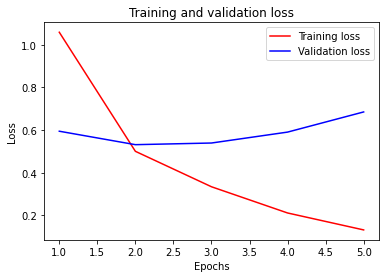

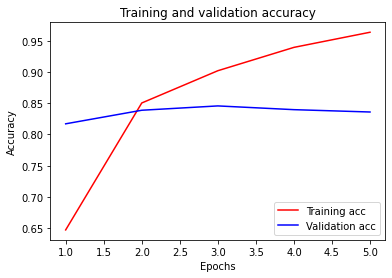

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

Bank account or service      0.760     0.790     0.774      1122
          Consumer Loan      0.584     0.670     0.624       682
            Credit card      0.854     0.731     0.788      1633
       Credit reporting      0.818     0.887     0.851      2527
        Debt collection      0.857     0.846     0.852      3524
        Money transfers      0.670     0.442     0.533       147
               Mortgage      0.929     0.943     0.936      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.200     0.007     0.013       149
           Prepaid card      0.806     0.773     0.789       194
           Student loan      0.669     0.841     0.745       377

               accuracy                          0.832     13362
              macro avg      0.650     0.630     0.628     13362
           weighted avg      0.827     0.832     0.826     13362


KFold: 2 starts.
Epoc

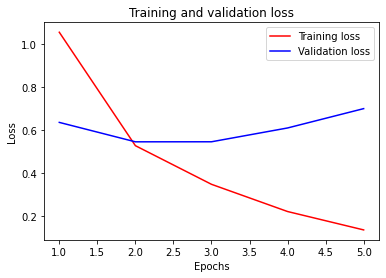

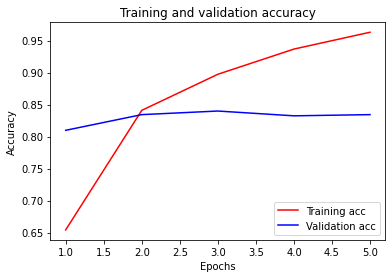

                         precision    recall  f1-score   support

Bank account or service      0.650     0.815     0.723      1122
          Consumer Loan      0.625     0.639     0.632       682
            Credit card      0.779     0.818     0.798      1633
       Credit reporting      0.900     0.837     0.868      2527
        Debt collection      0.831     0.891     0.860      3524
        Money transfers      1.000     0.014     0.027       147
               Mortgage      0.936     0.925     0.930      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.333     0.020     0.038       149
           Prepaid card      0.806     0.258     0.391       194
           Student loan      0.783     0.814     0.798       377

               accuracy                          0.828     13362
              macro avg      0.695     0.548     0.551     13362
           weighted avg      0.829     0.828     0.818     13362


KFold: 3 starts.
Epoc

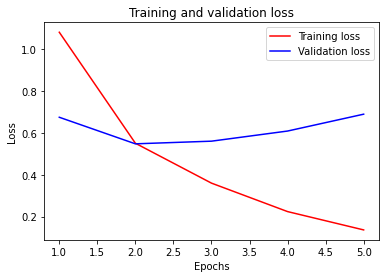

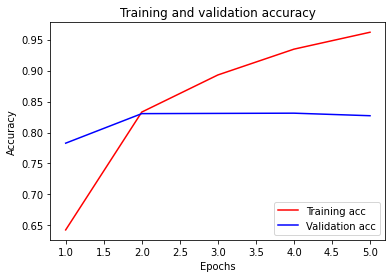

                         precision    recall  f1-score   support

Bank account or service      0.698     0.807     0.749      1122
          Consumer Loan      0.626     0.597     0.611       682
            Credit card      0.788     0.808     0.798      1633
       Credit reporting      0.868     0.848     0.858      2527
        Debt collection      0.833     0.872     0.852      3524
        Money transfers      0.000     0.000     0.000       147
               Mortgage      0.932     0.942     0.937      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.600     0.040     0.075       149
           Prepaid card      0.803     0.649     0.718       194
           Student loan      0.767     0.814     0.790       377

               accuracy                          0.831     13362
              macro avg      0.629     0.580     0.581     13362
           weighted avg      0.819     0.831     0.822     13362


KFold: 4 starts.
Epoc

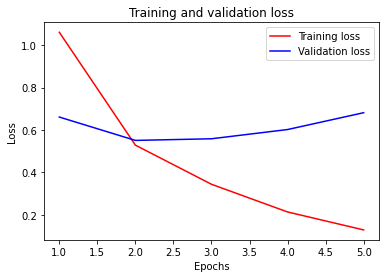

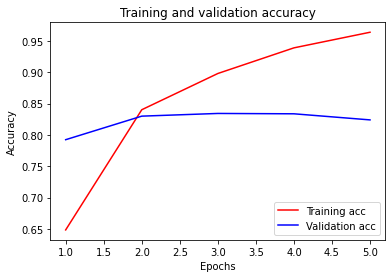

                         precision    recall  f1-score   support

Bank account or service      0.762     0.732     0.747      1122
          Consumer Loan      0.557     0.633     0.593       682
            Credit card      0.772     0.842     0.806      1633
       Credit reporting      0.840     0.876     0.857      2527
        Debt collection      0.858     0.835     0.846      3524
        Money transfers      0.545     0.082     0.142       147
               Mortgage      0.922     0.948     0.935      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.333     0.007     0.013       149
           Prepaid card      0.624     0.660     0.642       194
           Student loan      0.816     0.788     0.802       377

               accuracy                          0.827     13362
              macro avg      0.639     0.582     0.580     13362
           weighted avg      0.820     0.827     0.819     13362


KFold: 5 starts.
Epoc

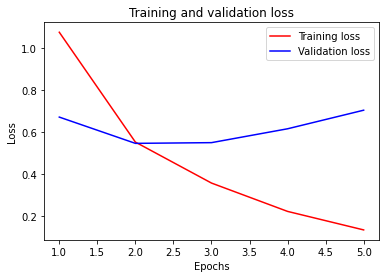

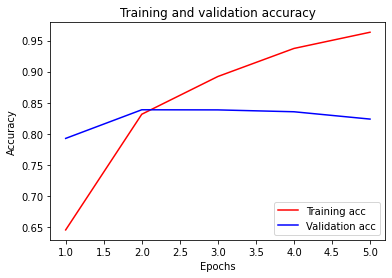

                         precision    recall  f1-score   support

Bank account or service      0.765     0.744     0.755      1122
          Consumer Loan      0.662     0.525     0.585       682
            Credit card      0.768     0.818     0.792      1633
       Credit reporting      0.863     0.849     0.856      2527
        Debt collection      0.823     0.890     0.855      3524
        Money transfers      0.745     0.259     0.384       147
               Mortgage      0.932     0.932     0.932      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.714     0.034     0.064       149
           Prepaid card      0.606     0.768     0.677       194
           Student loan      0.765     0.812     0.788       377

               accuracy                          0.830     13362
              macro avg      0.695     0.603     0.608     13362
           weighted avg      0.827     0.830     0.823     13362


KFold: 6 starts.
Epoc

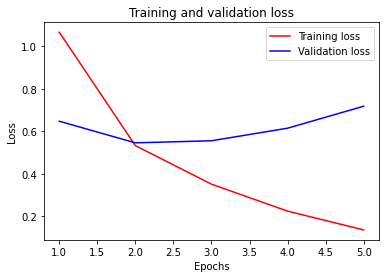

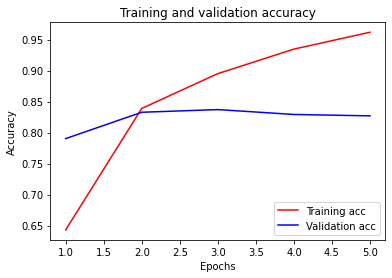

                         precision    recall  f1-score   support

Bank account or service      0.770     0.729     0.749      1122
          Consumer Loan      0.610     0.638     0.624       682
            Credit card      0.782     0.830     0.805      1633
       Credit reporting      0.889     0.825     0.856      2527
        Debt collection      0.819     0.891     0.854      3524
        Money transfers      0.842     0.109     0.193       147
               Mortgage      0.922     0.947     0.935      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.143     0.007     0.013       149
           Prepaid card      0.742     0.624     0.678       194
           Student loan      0.733     0.809     0.769       377

               accuracy                          0.831     13362
              macro avg      0.659     0.583     0.589     13362
           weighted avg      0.824     0.831     0.823     13362


KFold: 7 starts.
Epoc

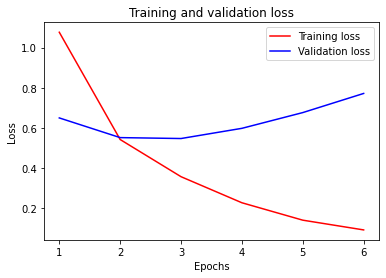

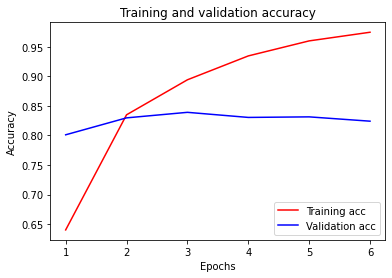

                         precision    recall  f1-score   support

Bank account or service      0.707     0.806     0.753      1122
          Consumer Loan      0.693     0.510     0.588       682
            Credit card      0.812     0.780     0.795      1633
       Credit reporting      0.838     0.866     0.852      2527
        Debt collection      0.825     0.881     0.852      3524
        Money transfers      0.761     0.367     0.495       147
               Mortgage      0.928     0.928     0.928      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.508     0.201     0.288       149
           Prepaid card      0.789     0.598     0.680       194
           Student loan      0.828     0.833     0.831       377

               accuracy                          0.831     13362
              macro avg      0.699     0.615     0.642     13362
           weighted avg      0.827     0.831     0.826     13362


KFold: 8 starts.
Epoc

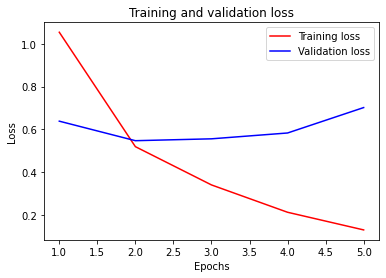

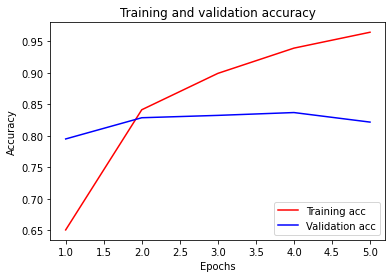

                         precision    recall  f1-score   support

Bank account or service      0.716     0.791     0.751      1122
          Consumer Loan      0.617     0.557     0.586       682
            Credit card      0.784     0.847     0.814      1633
       Credit reporting      0.835     0.878     0.856      2527
        Debt collection      0.855     0.850     0.853      3524
        Money transfers      0.667     0.163     0.262       147
               Mortgage      0.935     0.933     0.934      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.733     0.074     0.134       149
           Prepaid card      0.727     0.701     0.714       194
           Student loan      0.841     0.812     0.826       377

               accuracy                          0.833     13362
              macro avg      0.701     0.600     0.612     13362
           weighted avg      0.830     0.833     0.826     13362


KFold: 9 starts.
Epoc

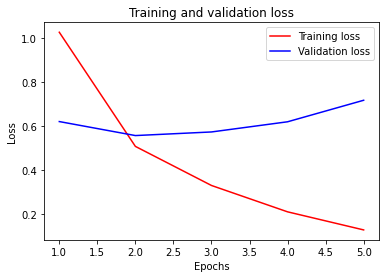

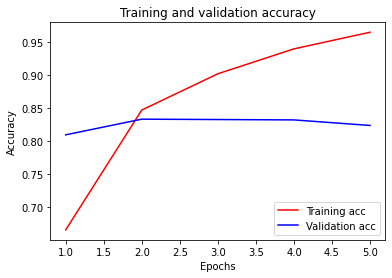

                         precision    recall  f1-score   support

Bank account or service      0.807     0.733     0.768      1122
          Consumer Loan      0.626     0.614     0.620       682
            Credit card      0.789     0.826     0.807      1633
       Credit reporting      0.877     0.840     0.858      2527
        Debt collection      0.810     0.891     0.849      3524
        Money transfers      0.670     0.469     0.552       147
               Mortgage      0.945     0.923     0.934      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.750     0.020     0.039       149
           Prepaid card      0.658     0.814     0.728       194
           Student loan      0.814     0.870     0.841       377

               accuracy                          0.836     13362
              macro avg      0.704     0.636     0.636     13362
           weighted avg      0.835     0.836     0.830     13362


KFold: 10 starts.
Epo

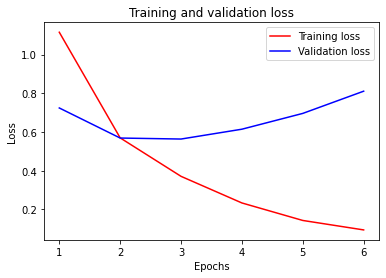

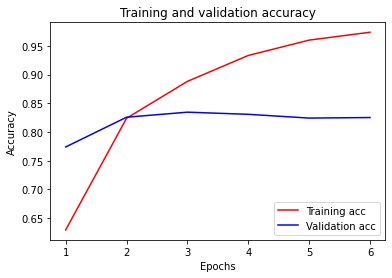

                         precision    recall  f1-score   support

Bank account or service      0.765     0.750     0.758      1122
          Consumer Loan      0.549     0.617     0.581       682
            Credit card      0.762     0.832     0.796      1633
       Credit reporting      0.910     0.823     0.864      2527
        Debt collection      0.833     0.879     0.855      3524
        Money transfers      0.741     0.429     0.543       147
               Mortgage      0.920     0.937     0.929      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.438     0.141     0.213       149
           Prepaid card      0.787     0.706     0.745       194
           Student loan      0.834     0.788     0.810       377

               accuracy                          0.832     13362
              macro avg      0.685     0.628     0.645     13362
           weighted avg      0.831     0.832     0.829     13362


Average accuracy: 0.8

In [9]:
# Create and train the model

earlystop_callback = EarlyStopping(
  monitor="val_loss",
  min_delta=0.0001,
  patience=earlystopping_patience,
  restore_best_weights=True)

process_X = ProcessX(x=X, input_dim=input_dim)
X_test_processed = process_X.process(x=X_test, padding="post", max_len=max_len)
y_test_processed, _, _ = process_y(y_test)

kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
model = None
cv_acc = []
cv_loss = []
cv_f1 = []

for n, (train, valid) in enumerate(kfold.split(X_train, y_train)):
  print("KFold: {} starts.".format(n + 1))
  del model
  tf.keras.backend.clear_session()

  X_train_split = X_train[train]
  y_train_split = y_train[train]
  X_valid_split = X_train[valid]
  y_valid_split = y_train[valid]

  X_train_split_processed = process_X.process(x=X_train_split, padding="post", max_len=max_len)
  y_train_split_processed, labels, label_names = process_y(y_train_split)
  X_valid_split_processed = process_X.process(x=X_valid_split, padding="post", max_len=max_len)
  y_valid_split_processed, _, _ = process_y(y_valid_split)

  model = Sequential([
    Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_len),
    Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"),
    MaxPool1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"),
    GlobalMaxPool1D(),
    Flatten(),
    # Hidden layers
    Dense(units=250, activation="relu"),
    Dropout(rate=0.2, noise_shape=None, seed=None),
    Dense(units=250, activation="relu"),
    Dropout(rate=0.2, noise_shape=None, seed=None),
    # Output layer
    Dense(units=num_classes, activation="sigmoid")
  ])

  model.compile(
      loss="categorical_crossentropy",
      optimizer="adam",
      metrics=["accuracy"]
  )

  # model.summary()

  history = model.fit(
      x=X_train_split_processed,
      y=y_train_split_processed,
      validation_data=(X_valid_split_processed, y_valid_split_processed),
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      callbacks=[earlystop_callback]
  )

  loss, acc = model.evaluate(x=X_test_processed, y=y_test_processed, verbose=1)
  cv_acc.append(acc)
  cv_loss.append(loss)

  plot_perf(history)

  # # np.argmax(model.predict(x), axis=-1), if your model does multi-class classification (e.g. if it uses a softmax last-layer activation).
  # (model.predict(x) > 0.5).astype("int32"), if your model does binary classification (e.g. if it uses a sigmoid last-layer activation).
  rounded_predictions = np.argmax(model.predict(X_test_processed), axis=-1)
  rounded_labels = np.argmax(y_test_processed, axis=1)
  report = classification_report(y_true=rounded_labels, y_pred=rounded_predictions, labels=labels, target_names=label_names, digits=3, output_dict=False)
  print(report)

  f1 = f1_score(y_true=rounded_labels, y_pred=rounded_predictions, average="weighted")
  cv_f1.append(f1)

  print("")

print("Average accuracy: {:.4f} (+/- {:.4f})".format(np.mean(cv_acc), np.std(cv_acc)))
print("Average loss: {:.4f} (+/- {:.4f})".format(np.mean(cv_loss), np.std(cv_loss)))
print("Average F1: {:.4f} (+/- {:.4f})".format(np.mean(cv_f1), np.std(cv_f1)))
